<a href="https://colab.research.google.com/github/armandordorica/Twitter_Sentiment_Analysis/blob/master/Covid19_NYC_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prediction of Covid 19 Cases**

The goal of this project is to analyze the evolution of Covid-19 cases in New York City. Particularly, we'd like to know if it's possible to improve univariate time series predictions by leveraging sentiment analysis on tweets related to Covid-19 in New York City area as well. 



The source data is coming from the World Health Organization and is updated daily. 

In [0]:
import pandas as pd
from pandas import read_csv
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
series = read_csv(url, header=0)


**Cleaning the data to keep New York data only**

In [412]:
series[series['Combined_Key'].str.match('New York')]

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
1863,84036061,US,USA,840,36061.0,New York,New York,US,40.767273,-73.971526,"New York City, New York, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,25,55,95,154,269,269,463,814,1871,3954,5151,7530,9654,12305,14904,17856,21873,25573,29776,33768,37453,43119,47439,51809,57159,63306,67551,72181,76876,81803,87028,92384,98308,103208,106763,110465,118302,123146,127352,135572


In [0]:
df = pd.DataFrame(series)
df_ny = df.iloc[1863]
df_ny = pd.DataFrame(df_ny)
df_ny = df_ny.T

cols = list(df_ny.columns)
df_ny = df_ny[cols[10:]]

In [414]:
df_ny

,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,...,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20
1863,"New York City, New York, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,25,55,95,154,269,269,463,814,1871,3954,5151,7530,9654,12305,14904,17856,21873,25573,29776,33768,37453,43119,47439,51809,57159,63306,67551,72181,76876,81803,87028,92384,98308,103208,106763,110465,118302,123146,127352,135572


In [0]:
list_of_dates= list(df_ny.columns)
list_of_dates = list_of_dates[40:]

list(df_ny.values)
values = list(df_ny.iloc[0])[40:]

In [416]:
data = {'Date':list_of_dates, 'Num of daily cases': values} 
df = pd.DataFrame(data)
df.head(20)

,Date,Num of daily cases
0,3/1/20,0
1,3/2/20,1
2,3/3/20,1
3,3/4/20,1
4,3/5/20,4
5,3/6/20,11
6,3/7/20,11
7,3/8/20,12
8,3/9/20,19
9,3/10/20,25


In [0]:
dates = list(df['Date'])
dates = pd.date_range(start=str(dates[0]),end=str(dates[-1]))
dates = list(dates)


list_of_dates =  []
for i in range(0, len(dates)):
  list_of_dates.append(dates[i].strftime("%b-%d"))

x_ticks= [list_of_dates[i] for i in range(0, len(list_of_dates), 5)]

([<matplotlib.axis.XTick at 0x7f0dd6559c88>,
 <a list of 10 Text major ticklabel objects>)

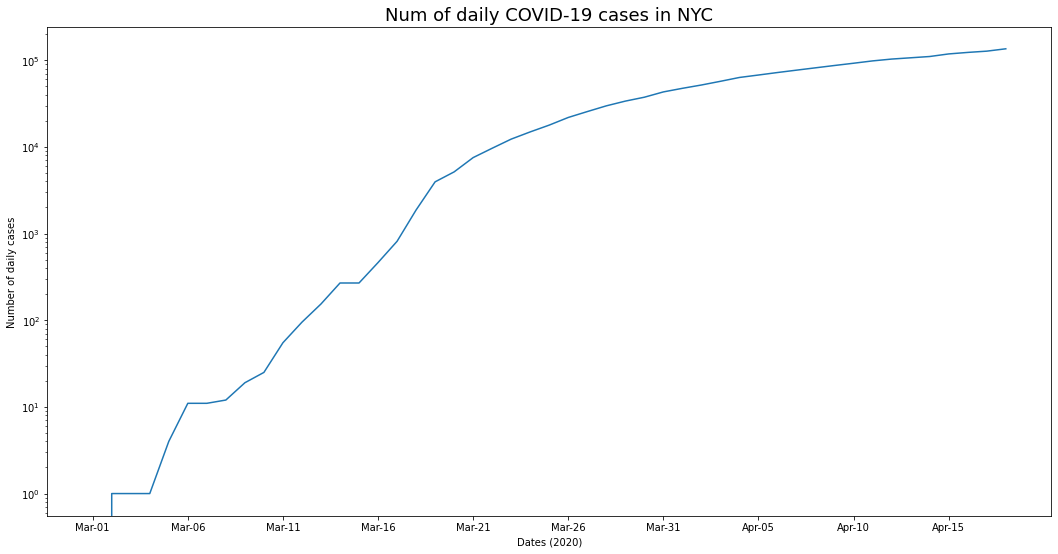

In [478]:
from matplotlib import pyplot as plt

plt.figure(figsize = (18,9))
plt.yscale("log")

plt.title("Num of daily COVID-19 cases in NYC", fontsize = 18)
plt.plot(list_of_dates, df['Num of daily cases'])
plt.ylabel("Number of daily cases")
plt.xlabel("Dates (2020)")
plt.xticks(x_ticks)

### Setting up our baseline model

The parameters of the ARIMA model are defined as follows:

* p: The number of lag observations included in the model, also called the lag order.
* d: The number of times that the raw observations are differenced, also called the degree of differencing.
* q: The size of the moving average window, also called the order of moving average.

For the purpose of this analysis, I have chosen `order=(3,0,0)`.

In [0]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)

In [0]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [421]:
series = df['Num of daily cases']
series.index = df['Date']
series.shape

(49,)

### Now we'll split dataset in training and validation. 

In [422]:
validation_size =round(len(series)*.2)
split_point = len(series) -validation_size 

print("The size of our validation set is: {}, which corresponds to 20% of our examples.".format(validation_size))

dataset, validation = series[0:split_point], series[split_point:]

print("The training set goes from {} to {} and the validation set goes from {} to {}".format(dataset.index[0], dataset.index[-1], validation.index[0], validation.index[-1] ))

The size of our validation set is: 10, which corresponds to 20% of our examples.
The training set goes from 3/1/20 to 4/8/20 and the validation set goes from 4/9/20 to 4/18/20


In [423]:
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
import numpy
 
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)
 
# load dataset
# seasonal difference
X = dataset.values
days_in_year = 1
differenced = difference(X, days_in_year)
# fit model
model = ARIMA(differenced, order=(7,0,0))
model_fit = model.fit(disp=0)
# print summary of fit model
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                   38
Model:                     ARMA(7, 0)   Log Likelihood                -293.533
Method:                       css-mle   S.D. of innovations            515.376
Date:                Sun, 19 Apr 2020   AIC                            605.066
Time:                        23:50:45   BIC                            619.804
Sample:                             0   HQIC                           610.310
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1935.4679    879.539      2.201      0.036     211.602    3659.334
ar.L1.y        0.3081      0.161      1.919      0.065      -0.007       0.623
ar.L2.y        0.3697      0.156      2.371      0.0

In [424]:
len(dataset)

39

In [425]:
len(validation)

10

In [0]:
# one-step out of sample forecast
start_index = len(differenced)
end_index = len(differenced)
forecast = model_fit.predict(start=start_index, end=end_index)

In [427]:
from pandas import datetime
# invert the differenced forecast to something usable
forecast = inverse_difference(X, forecast, days_in_year)
print('Forecast: %f' % forecast)

Forecast: 85771.094729


In [0]:
# multi-step out-of-sample forecast
num_steps = 10
forecast = model_fit.forecast(steps=num_steps)[0]

In [429]:
forecast_one_week_ahead = []
history = [x for x in X]
day = 1
for yhat in forecast:
	inverted = inverse_difference(history, yhat, days_in_year)
	print('Day %d: %f' % (day, inverted))
	history.append(inverted)
	day += 1

Day 1: 85771.094729
Day 2: 89495.019766
Day 3: 93407.251220
Day 4: 97067.539606
Day 5: 100134.304754
Day 6: 102955.519937
Day 7: 105747.126035
Day 8: 108271.406274
Day 9: 110369.656892
Day 10: 112261.517852


In [0]:
pd.DataFrame(history).to_csv("history.csv")

In [431]:
validation[:num_steps]

Date
4/9/20      87028
4/10/20     92384
4/11/20     98308
4/12/20    103208
4/13/20    106763
4/14/20    110465
4/15/20    118302
4/16/20    123146
4/17/20    127352
4/18/20    135572
Name: Num of daily cases, dtype: int64

In [432]:
print("For the next {} days, from {} the values forecasted are: {}. \nThe true values are:{} ".format(num_steps, dataset.index[-1], history[-num_steps:], validation[:num_steps]))

For the next 10 days, from 4/8/20 the values forecasted are: [85771.09472933489, 89495.01976560151, 93407.25122042082, 97067.53960558794, 100134.3047537031, 102955.51993689436, 105747.12603464875, 108271.40627377042, 110369.65689195148, 112261.51785234839]. 
The true values are:Date
4/9/20      87028
4/10/20     92384
4/11/20     98308
4/12/20    103208
4/13/20    106763
4/14/20    110465
4/15/20    118302
4/16/20    123146
4/17/20    127352
4/18/20    135572
Name: Num of daily cases, dtype: int64 


In [0]:
import numpy as np
history_np = np.array(history)

Text(0.5, 1.0, 'Num of daily COVID-19 cases in NYC')

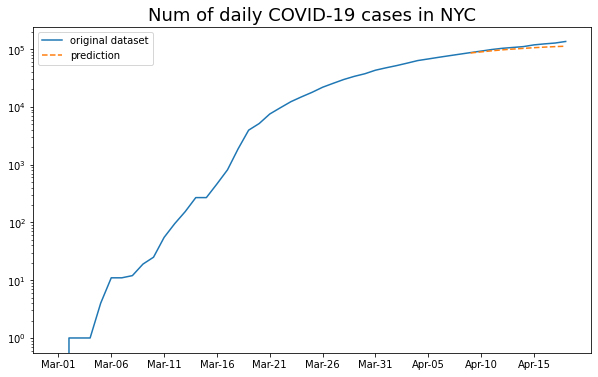

In [473]:
plt.figure(figsize = (10,6))

plt.yscale("log")
plt.plot(list_of_dates, list(series)[-50:], label = 'original dataset' )
plt.plot(list_of_dates[-10:], history[-10:], label = 'prediction' , ls = 'dashed')
plt.xticks(x_ticks)
plt.legend()

plt.title("Num of daily COVID-19 cases in NYC", fontsize = 18)


In [0]:
true_values = list(series)[-10:]

In [0]:
predicted_values = list(history[-10:])

In [0]:
data = {'true_values': true_values, 
        'predicted_values': predicted_values}
comparison = pd.DataFrame(data)

In [453]:
log_comparison = np.log10(comparison)
log_comparison


,true_values,predicted_values
0,4.939659,4.933341
1,4.965597,4.951799
2,4.992589,4.970381
3,5.013713,4.987074
4,5.028421,5.000583
5,5.043225,5.012650
6,5.072992,5.024269
7,5.090420,5.034514
8,5.105006,5.042850
9,5.132170,5.050231


In [0]:
log_comparison['error']= (log_comparison['true_values'] - log_comparison['predicted_values'])/log_comparison['true_values']

On the plot below we can see that the prediction error is very low even for far ahead values. 

Forecasting using ARIMA can be thought of as a random process modeled as a random walk, where variance increases with time. Since the error depends on the variance, it also increases linearly (parabolically) with time.

The ARIMA model was trained on only 39 examples and it has been able to predict 10 days ahead with less than 2% error.   

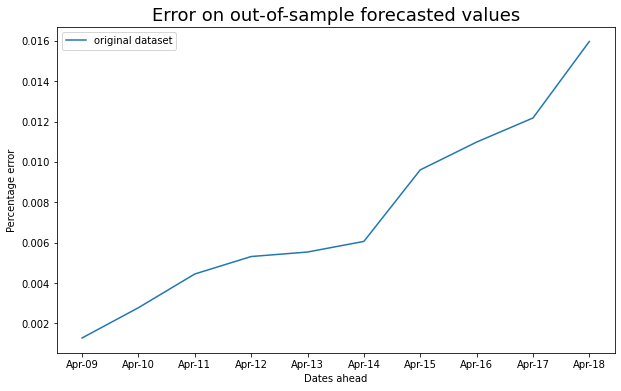

In [480]:
log_comparison['error']

plt.figure(figsize = (10,6))

plt.plot(list_of_dates[-10:], log_comparison['error'], label = 'original dataset' )
plt.title("Error on out-of-sample forecasted values", fontsize = 18)
plt.ylabel("Percentage error")
plt.xlabel("Dates ahead")

plt.legend()


### **Twitter Sentiment Analysis**
The following section performs sentiment analysis on Twitter data

In [492]:
url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"
series = read_csv(url, header=0)
series[series['Combined_Key'].str.match('New York')]

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20
1863,84036061,US,USA,840,36061.0,New York,New York,US,40.767273,-73.971526,"New York City, New York, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,55,95,154,269,269,463,814,1871,3954,5151,7530,9654,12305,14904,17856,21873,25573,29776,33768,37453,43119,47439,51809,57159,63306,67551,72181,76876,81803,87028,92384,98308,103208,106763,110465,118302,123146,127352,135572,138700


In [0]:
df = pd.DataFrame(series)
df_ny = df.iloc[1863]
df_ny = pd.DataFrame(df_ny)
df_ny = df_ny.T

In [494]:
df_ny

,UID,iso2,iso3,code3,FIPS,Admin2,Province_State,Country_Region,Lat,Long_,Combined_Key,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,...,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20,4/5/20,4/6/20,4/7/20,4/8/20,4/9/20,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20
1863,84036061,US,USA,840,36061,New York,New York,US,40.7673,-73.9715,"New York City, New York, US",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,55,95,154,269,269,463,814,1871,3954,5151,7530,9654,12305,14904,17856,21873,25573,29776,33768,37453,43119,47439,51809,57159,63306,67551,72181,76876,81803,87028,92384,98308,103208,106763,110465,118302,123146,127352,135572,138700


In [496]:
cols = list(df_ny.columns)
df_ny = df_ny[cols[10:]]
df_ny = df_ny[['Combined_Key','3/4/20',
       '3/5/20', '3/6/20', '3/7/20', '3/8/20', '3/9/20', '3/10/20', '3/11/20',
       '3/12/20', '3/13/20', '3/14/20', '3/15/20', '3/16/20', '3/17/20',
       '3/18/20', '3/19/20', '3/20/20', '3/21/20', '3/22/20', '3/23/20',
       '3/24/20', '3/25/20', '3/26/20', '3/27/20', '3/28/20']]
df_ny = df_ny.T
df_ny.head()

,1863
Combined_Key,"New York City, New York, US"
3/4/20,1
3/5/20,4
3/6/20,11
3/7/20,11
3/8/20,12
3/9/20,19
3/10/20,25
3/11/20,55
3/12/20,95


In [497]:
import datetime
base = datetime.datetime(2020, 3, 28)
date_list = [base - datetime.timedelta(days=x) for x in range(25)]

list_of_dates =  []
for i in range(0, len(date_list)):
  list_of_dates.append(date_list[i].strftime("%Y-%m-%d"))

list_of_dates.reverse()
list_of_dates

['2020-03-04',
 '2020-03-05',
 '2020-03-06',
 '2020-03-07',
 '2020-03-08',
 '2020-03-09',
 '2020-03-10',
 '2020-03-11',
 '2020-03-12',
 '2020-03-13',
 '2020-03-14',
 '2020-03-15',
 '2020-03-16',
 '2020-03-17',
 '2020-03-18',
 '2020-03-19',
 '2020-03-20',
 '2020-03-21',
 '2020-03-22',
 '2020-03-23',
 '2020-03-24',
 '2020-03-25',
 '2020-03-26',
 '2020-03-27',
 '2020-03-28']

In [0]:
list_of_lists = df_ny.iloc[1:].values
flattened_values  = [val for sublist in list_of_lists for val in sublist]

In [499]:
len(flattened_values)

25

In [500]:
len(list_of_dates)

25

In [0]:
d = {'date': list_of_dates, 'Num of Cases in NY': flattened_values}

In [0]:
df = pd.DataFrame(data=d)

### Getting the Twitter data

In [505]:
url = "https://raw.githubusercontent.com/armandordorica/Twitter_Sentiment_Analysis/master/raw_data/ny_covid_twitter_data.csv"
from pandas import read_csv
twitter_df = read_csv(url, header=0)
twitter_df.head()

,Unnamed: 0,created_at,text,source,is_quote,is_retweet,favourites_count,retweet_count,place_full_name,place_type,followers_count,friends_count,account_created_at
0,48,2020-03-04T11:22:46Z,Can &amp; focus on tackling potential Corona...,Twitter for iPhone,False,False,25462.0,0.0,"Queens, NY",city,12378.0,13567.0,2009-01-21T21:17:54Z
1,1111,2020-03-04T13:46:00Z,(3/3) \n🧳 Self-evaluation of inherent bias/rac...,Twitter for iPhone,False,False,6366.0,0.0,"Manhattan, NY",city,656.0,829.0,2017-12-03T21:45:57Z
2,1701,2020-03-04T14:39:30Z,Sensible feedback on the CoronavirusOutbreak,Twitter for iPhone,True,False,1623.0,0.0,"Manhattan, NY",city,248.0,1309.0,2018-02-06T22:46:58Z
3,1737,2020-03-04T14:41:57Z,Bill Gates tried to warn us 4 years ago about ...,Twitter for Android,False,False,39912.0,0.0,"Brooklyn, NY",city,1511.0,2619.0,2009-06-19T20:33:46Z
4,2344,2020-03-04T15:44:59Z,👀😁CoronavirusOutbreak,Twitter for iPhone,False,False,41637.0,0.0,"New York, NY",admin,358.0,563.0,2019-05-08T11:02:45Z


In [0]:
df_ny = twitter_df

In [0]:
from textblob import TextBlob

# Create a function to get the subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
    return  TextBlob(text).sentiment.polarity

In [515]:
getSubjectivity(df_ny['text'][0])

0.65

In [517]:
df_ny.dropna(subset=['text'])

,Unnamed: 0,created_at,text,source,is_quote,is_retweet,favourites_count,retweet_count,place_full_name,place_type,followers_count,friends_count,account_created_at
0,48,2020-03-04T11:22:46Z,Can &amp; focus on tackling potential Corona...,Twitter for iPhone,False,False,25462.0,0.0,"Queens, NY",city,12378.0,13567.0,2009-01-21T21:17:54Z
1,1111,2020-03-04T13:46:00Z,(3/3) \n🧳 Self-evaluation of inherent bias/rac...,Twitter for iPhone,False,False,6366.0,0.0,"Manhattan, NY",city,656.0,829.0,2017-12-03T21:45:57Z
2,1701,2020-03-04T14:39:30Z,Sensible feedback on the CoronavirusOutbreak,Twitter for iPhone,True,False,1623.0,0.0,"Manhattan, NY",city,248.0,1309.0,2018-02-06T22:46:58Z
3,1737,2020-03-04T14:41:57Z,Bill Gates tried to warn us 4 years ago about ...,Twitter for Android,False,False,39912.0,0.0,"Brooklyn, NY",city,1511.0,2619.0,2009-06-19T20:33:46Z
4,2344,2020-03-04T15:44:59Z,👀😁CoronavirusOutbreak,Twitter for iPhone,False,False,41637.0,0.0,"New York, NY",admin,358.0,563.0,2019-05-08T11:02:45Z
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20687,15443927,2020-03-25T23:13:33Z,Takeout in the age of coronavirus:\n\nStep 1: ...,Twitter for iPhone,False,False,20.0,0.0,"New York, NY",admin,3.0,11.0,2020-03-07T05:35:22Z
20688,15447672,2020-03-25T23:22:18Z,JOIN US LIVE: We might be isolated and SocialD...,Twitter for Android,False,False,850.0,2.0,"New York, NY",admin,1243.0,954.0,2008-12-12T16:25:35Z
20689,15453231,2020-03-25T23:34:43Z,COVID19,Twitter for iPhone,False,False,17646.0,0.0,"New York, USA",admin,1312.0,2165.0,2008-10-27T19:40:19Z
20690,15453397,2020-03-25T23:35:05Z,"Missing the Broadcast Center, missing the tea...",Twitter for Android,False,False,294926.0,0.0,"New York, NY",admin,1394.0,1369.0,2010-09-12T17:17:03Z


In [0]:
df_ny= df_ny.dropna(subset=['text'])


In [530]:
df_ny['Subjectivity'] = df_ny['text'].apply(getSubjectivity)
df_ny['Polarity'] = df_ny['text'].apply(getPolarity)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [531]:
df_ny

,Unnamed: 0,created_at,text,source,is_quote,is_retweet,favourites_count,retweet_count,place_full_name,place_type,followers_count,friends_count,account_created_at,Subjectivity,Polarity
0,48,2020-03-04T11:22:46Z,Can &amp; focus on tackling potential Corona...,Twitter for iPhone,False,False,25462.0,0.0,"Queens, NY",city,12378.0,13567.0,2009-01-21T21:17:54Z,0.650000,0.500000
1,1111,2020-03-04T13:46:00Z,(3/3) \n🧳 Self-evaluation of inherent bias/rac...,Twitter for iPhone,False,False,6366.0,0.0,"Manhattan, NY",city,656.0,829.0,2017-12-03T21:45:57Z,0.472727,0.113636
2,1701,2020-03-04T14:39:30Z,Sensible feedback on the CoronavirusOutbreak,Twitter for iPhone,True,False,1623.0,0.0,"Manhattan, NY",city,248.0,1309.0,2018-02-06T22:46:58Z,0.000000,0.000000
3,1737,2020-03-04T14:41:57Z,Bill Gates tried to warn us 4 years ago about ...,Twitter for Android,False,False,39912.0,0.0,"Brooklyn, NY",city,1511.0,2619.0,2009-06-19T20:33:46Z,0.477273,0.018182
4,2344,2020-03-04T15:44:59Z,👀😁CoronavirusOutbreak,Twitter for iPhone,False,False,41637.0,0.0,"New York, NY",admin,358.0,563.0,2019-05-08T11:02:45Z,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20687,15443927,2020-03-25T23:13:33Z,Takeout in the age of coronavirus:\n\nStep 1: ...,Twitter for iPhone,False,False,20.0,0.0,"New York, NY",admin,3.0,11.0,2020-03-07T05:35:22Z,0.638889,0.055556
20688,15447672,2020-03-25T23:22:18Z,JOIN US LIVE: We might be isolated and SocialD...,Twitter for Android,False,False,850.0,2.0,"New York, NY",admin,1243.0,954.0,2008-12-12T16:25:35Z,0.500000,0.136364
20689,15453231,2020-03-25T23:34:43Z,COVID19,Twitter for iPhone,False,False,17646.0,0.0,"New York, USA",admin,1312.0,2165.0,2008-10-27T19:40:19Z,0.000000,0.000000
20690,15453397,2020-03-25T23:35:05Z,"Missing the Broadcast Center, missing the tea...",Twitter for Android,False,False,294926.0,0.0,"New York, NY",admin,1394.0,1369.0,2010-09-12T17:17:03Z,0.125000,-0.041667


In [0]:
allWords = ' '.join([twts for twts in df_ny['text']])


In [0]:

from wordcloud import WordCloud

wordCloud = WordCloud(width=500, height=300, random_state=21, max_font_size=110).generate(allWords)

In [0]:
plt.style.use('classic')


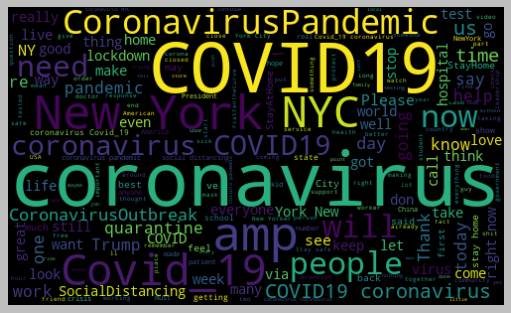

In [587]:

plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [0]:
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

In [589]:
df_ny['Analysis'] = df_ny['Polarity'].apply(getAnalysis)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
sortedDF = df_ny.sort_values(by=['Polarity'])


In [0]:
sortedDF = sortedDF.reset_index(drop=True)


In [0]:
sortedDF = sortedDF[list(sortedDF.columns)[1:]]

In [593]:
sortedDF.head(1)

,created_at,text,source,is_quote,is_retweet,favourites_count,retweet_count,place_full_name,place_type,followers_count,friends_count,account_created_at,Subjectivity,Polarity,Analysis
0,2020-03-17T13:26:02Z,This is a cruel tease. COVID19 covidncancer PP...,Twitter for iPhone,True,False,13973.0,0.0,"Manhattan, NY",city,5650.0,5473.0,2013-03-05T23:23:23Z,1.0,-1.0,Negative


### Printing a sample of negative tweets

In [594]:
for i in range(1, 10):
    print(str(i) + ') ' + sortedDF.iloc[i].text)
    print()

1) SUNY CUNY   you guys literally DONT CARE about the safety of your students. This is absolutely DISGUSTING.

Why does it need to affect a STUDENT for you guys to CloseTheSchools CoronavirusOutbreak coronaVirus Coronavirusny 

2) Geraldo Rivera Clashes With Dan Bongino Over Trump Travel Ban...These ppl are insane!  coronavirus  

3) Yyyooooooo y’all motherfuckers are RUTHLESS 😭😭😭‼️‼️‼️

🤦🏾‍♀️🤦🏾‍♀️🤦🏾‍♀️ coronavirus 

4) This is just disgusting. COVID19 theranos SoftBank patenttroll 

5) This is outrageous &amp; U wonder why there is panic over COVID19... StayHome StopTheSpread FlattenTheCurve WashYourHands DontPanic YouGottaLaugh NotMyPhoto COMMONSENSEMATTERS WeWillSurvive HomemadeHazMatSuit     

6) In Syria's prisons, 10000s languish in horrific humanitarian conditions. Even one case of COVID19 there would be catastrophic. That's why humanitarian organizations and UN agencies must urgently press for access. 

7)  what’s your plan for when employees get sick!!! No plan for paid time o

In [595]:
inverseSortedDF = df_ny.sort_values(by=['Polarity'], ascending= False)
inverseSortedDF.head(1)

,Unnamed: 0,created_at,text,source,is_quote,is_retweet,favourites_count,retweet_count,place_full_name,place_type,followers_count,friends_count,account_created_at,Subjectivity,Polarity,Analysis
11231,8976443,2020-03-21T03:27:54Z,crowdsourcing masks\nhow can u help?\nmet elia...,Twitter for iPhone,False,False,10695.0,1.0,"Manhattan, NY",city,4620.0,3302.0,2008-01-06T01:37:22Z,0.9,1.0,Positive


In [596]:
inverseSortedDF = inverseSortedDF[list(inverseSortedDF.columns)[1:]]
inverseSortedDF.head(1)

,created_at,text,source,is_quote,is_retweet,favourites_count,retweet_count,place_full_name,place_type,followers_count,friends_count,account_created_at,Subjectivity,Polarity,Analysis
11231,2020-03-21T03:27:54Z,crowdsourcing masks\nhow can u help?\nmet elia...,Twitter for iPhone,False,False,10695.0,1.0,"Manhattan, NY",city,4620.0,3302.0,2008-01-06T01:37:22Z,0.9,1.0,Positive


Printing a sample of positive tweets 

In [597]:
for i in range(1, 10):
    print(str(i) + ') ' + inverseSortedDF.iloc[i].text)
    print()

1)  are awesome! COVID19

2) Is this the best decision to move ahead with  meeting? Cc   COVID19 coronavirus 

3) A Doctor friend passed this along and suggested I share. 

It illustrates perfectly how the virus infects you and answers a lot of questions you may have. 

CoronavirusPandemic 

4) Mother knows best! coronavirus TrumpRecession CoronavirusOutbreak  

5) Proud to organize with my students! sickout closenyschools CloseTheSchools coronapocolypse coronavirus COVIDー19 COVID19 NYCDOE 

6) One of the best Memes of the WuhanVirus CoronaVirus ChineseFlu 👇👇👇👇👇 

7) We should require everyone to read/watch this before their phones will work again. That would be the best national emergency alert system ever - compliance training via mobile OS takeover. Thoughts   ??  pivotpodcast COVID19

8) Happy to announce that 46 will be joining us for pancchat tonight! Tune in at 8pm EST to tweet all things COVID19 CoronavirusOutbreak covidncancer TuesdayMotivation QuarantineLife 

9)  This seems 

In [598]:
# Print the percentage of positive tweetsptweets = df_ny[df_ny.Analysis == 'Positive']
ptweets = df_ny[df_ny.Analysis == 'Positive']
ptweets = ptweets['text']
ptweets

round( (ptweets.shape[0] / df_ny.shape[0]) * 100 , 1)

47.0

In [599]:
# Print the percentage of negative tweets
ntweets = df_ny[df_ny.Analysis == 'Negative']
ntweets = ntweets['text']
ntweets

round( (ntweets.shape[0] / df_ny.shape[0]) * 100, 1)

20.0

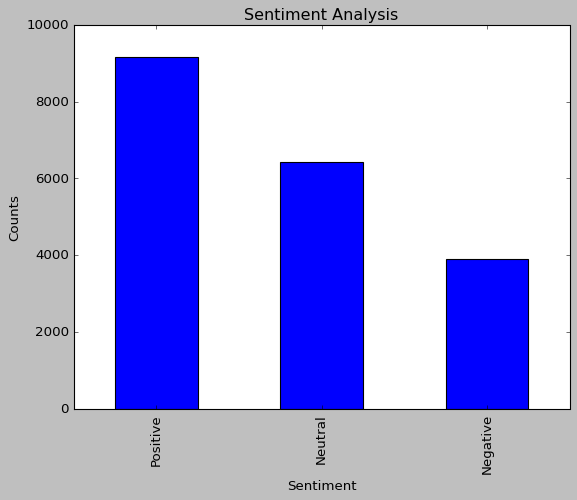

In [600]:
# Show the value counts
df_ny['Analysis'].value_counts()

# Plotting and visualizing the counts
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
df_ny['Analysis'].value_counts().plot(kind = 'bar')
plt.show()

### Creating time series of positive tweets only

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

Text(0.5, 1.0, 'positive tweets regarding Covid 19')

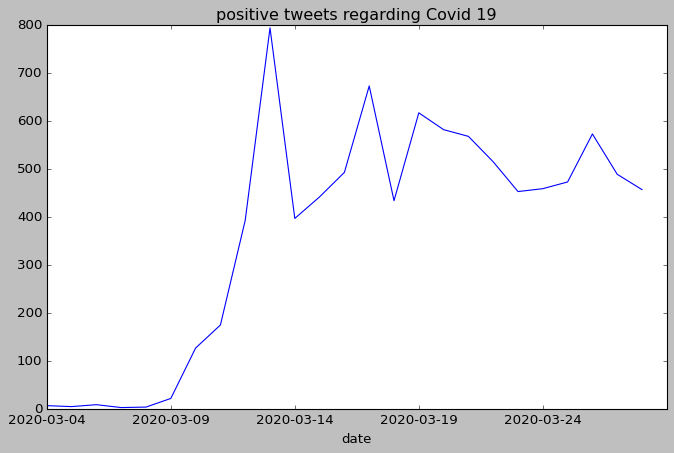

In [609]:
df_ny_pos = df_ny[df_ny['Analysis']=='Positive']

### Created at time stamp into YYYY-MM-DD date format 
df_ny_pos['date'] = df_ny_pos['created_at'].iloc[9163][0:10:1]

for i in range(0, len(df_ny_pos)):
    df_ny_pos['date'].iloc[i]= df_ny_pos['created_at'].iloc[i][0:10:1]

df_ny_pos = df_ny_pos[list(df_ny_pos.columns)[1:]]

# plt.style.context('dark_background')
plt.figure(figsize=(10,6))

df_ny_pos.groupby('date').count()['created_at'].plot()
plt.title("positive tweets regarding Covid 19")

### Now we'll get time series for neutral and negative comments as well

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

Text(0.5, 1.0, 'Negative tweets regarding Covid 19')

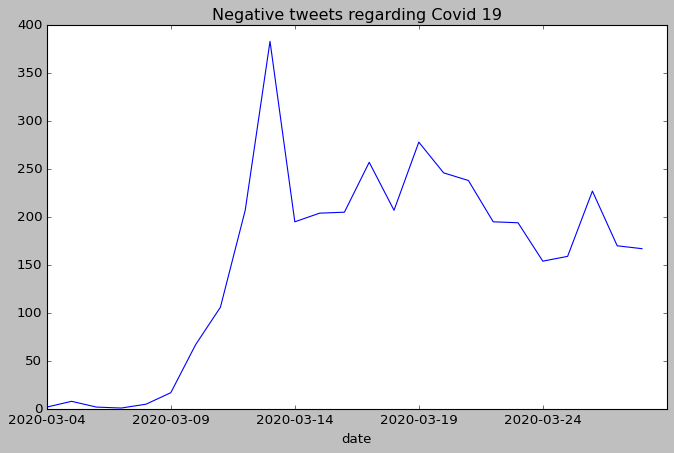

In [616]:
df_ny_neg = df_ny[df_ny['Analysis']=='Negative']

### Created at time stamp into YYYY-MM-DD date format 
df_ny_neg['date'] = df_ny_neg['created_at'].iloc[0][0:10:1]

for i in range(0, len(df_ny_neg)):
    df_ny_neg['date'].iloc[i]= df_ny_neg['created_at'].iloc[i][0:10:1]

df_ny_neg = df_ny_neg[list(df_ny_neg.columns)[1:]]

# plt.style.context('dark_background')
plt.figure(figsize=(10,6))

df_ny_neg.groupby('date').count()['created_at'].plot()
plt.title("Negative tweets regarding Covid 19")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

Text(0.5, 1.0, 'Neutral tweets regarding Covid 19')

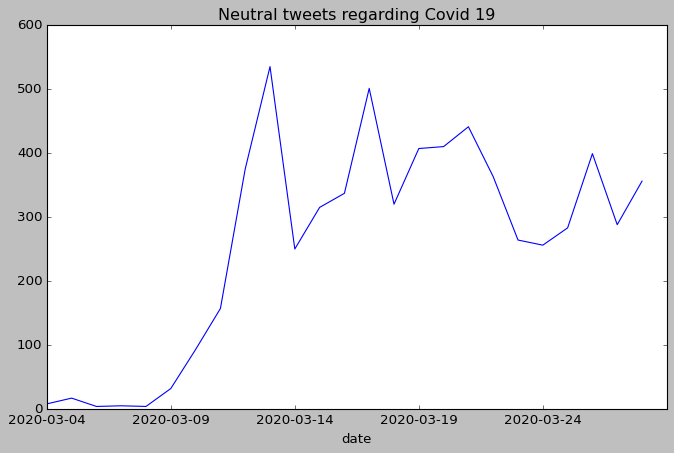

In [620]:
df_ny_neutral = df_ny[df_ny['Analysis']=='Neutral']

### Created at time stamp into YYYY-MM-DD date format 
df_ny_neutral['date'] = df_ny_neutral['created_at'].iloc[0][0:10:1]

for i in range(0, len(df_ny_neutral)):
    df_ny_neutral['date'].iloc[i]= df_ny_neutral['created_at'].iloc[i][0:10:1]

df_ny_neutral = df_ny_neutral[list(df_ny_neutral.columns)[1:]]

# plt.style.context('dark_background')
plt.figure(figsize=(10,6))

df_ny_neutral.groupby('date').count()['created_at'].plot()
plt.title("Neutral tweets regarding Covid 19")

In [623]:
df_ny['date'] = df_ny['created_at'].iloc[0][0:10:1]

for i in range(0, len(df_ny)):
    df_ny['date'].iloc[i]= df_ny['created_at'].iloc[i][0:10:1]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/inde

In [0]:
all_series = df_ny.groupby('date').count()['created_at']
pos_series = df_ny_pos.groupby('date').count()['created_at']
neg_series = df_ny_neg.groupby('date').count()['created_at']
neutral_series = df_ny_neutral.groupby('date').count()['created_at']


In [0]:
df1 = pd.merge(all_series, pos_series, on='date', how='left')
df2 = pd.merge(df1, neg_series, on='date', how='left')
df3 = pd.merge(df2, neutral_series, on='date', how='left')
df3.columns = ['all tweets', 'positive tweets', 'negative tweets', 'neutral tweets']
df3['Total'] = df3['positive tweets'] + df3['negative tweets'] + df3['neutral tweets']
df3.to_csv("sentiment_analysis_time_series_nyc_twitter.csv")


In [628]:
df3

,all tweets,positive tweets,negative tweets,neutral tweets,Total
date,,,,,
2020-03-04,17,7,2,8,17
2020-03-05,30,5,8,17,30
2020-03-06,15,9,2,4,15
2020-03-07,9,3,1,5,9
2020-03-08,13,4,5,4,13
2020-03-09,71,22,17,32,71
2020-03-10,287,127,67,93,287
2020-03-11,438,175,106,157,438
2020-03-12,975,393,207,375,975


In [0]:
merged_df = pd.merge(df, df3, on='date', how='inner')

In [0]:
merged_df = merged_df[['Num of Cases in NY','positive tweets',
       'negative tweets', 'neutral tweets', 'Total']]

In [0]:
merged_df.index= df3.index

In [640]:
merged_df

,Num of Cases in NY,positive tweets,negative tweets,neutral tweets,Total
date,,,,,
2020-03-04,1,7,2,8,17
2020-03-05,4,5,8,17,30
2020-03-06,11,9,2,4,15
2020-03-07,11,3,1,5,9
2020-03-08,12,4,5,4,13
2020-03-09,19,22,17,32,71
2020-03-10,25,127,67,93,287
2020-03-11,55,175,106,157,438
2020-03-12,95,393,207,375,975


In [641]:
merged_df['Total']

date
2020-03-04      17
2020-03-05      30
2020-03-06      15
2020-03-07       9
2020-03-08      13
2020-03-09      71
2020-03-10     287
2020-03-11     438
2020-03-12     975
2020-03-13    1712
2020-03-14     842
2020-03-15     961
2020-03-16    1035
2020-03-17    1431
2020-03-18     961
2020-03-19    1302
2020-03-20    1238
2020-03-21    1247
2020-03-22    1073
2020-03-23     911
2020-03-24     869
2020-03-25     915
2020-03-26    1199
2020-03-27     947
2020-03-28     980
Name: Total, dtype: int64

In [0]:
list_of_dates_twitter = list(merged_df['Total'].index)

In [0]:
x_ticks_twitter= [list_of_dates_twitter[i] for i in range(0, len(list_of_dates_twitter), 5)]

In [645]:
x_ticks_twitter

['2020-03-04', '2020-03-09', '2020-03-14', '2020-03-19', '2020-03-24']

No handles with labels found to put in legend.


Text(0.5, 1.0, 'Num of daily tweets related to COVID-19 in NYC area')

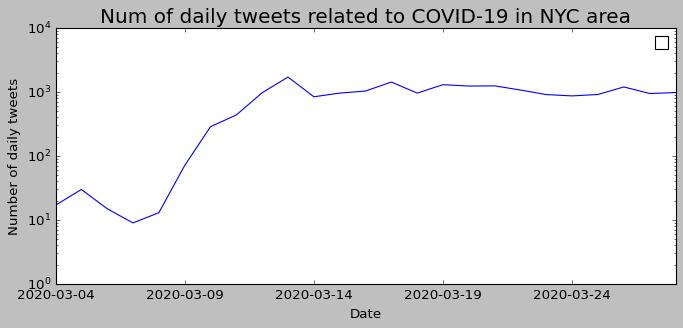

In [662]:
plt.figure(figsize = (10,4))

plt.yscale("log")
plt.plot(merged_df['Total'].index, merged_df['Total'] )
plt.xticks(x_ticks_twitter)
plt.ylabel("Number of daily tweets")
plt.xlabel("Date")
plt.legend()

plt.title("Num of daily tweets related to COVID-19 in NYC area", fontsize = 18)

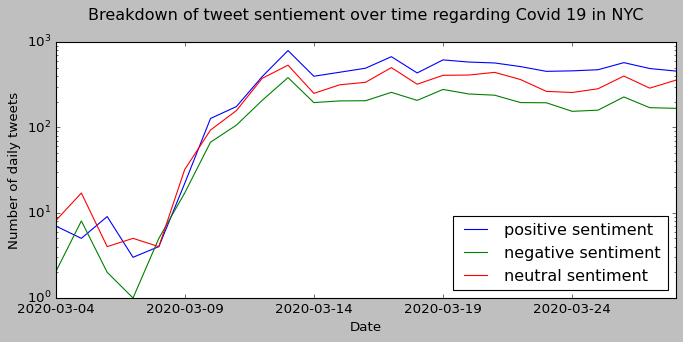

In [661]:
plt.figure(figsize = (10,4))

plt.yscale("log")
plt.plot(merged_df['positive tweets'].index, merged_df['positive tweets'], label="positive sentiment")
plt.plot(merged_df['positive tweets'].index, merged_df['negative tweets'], label='negative sentiment')
plt.plot(merged_df['positive tweets'].index, merged_df['neutral tweets'], label='neutral sentiment')
plt.xticks(x_ticks_twitter)
plt.title("Breakdown of tweet sentiement over time regarding Covid 19 in NYC", pad =20)
plt.ylabel("Number of daily tweets")
plt.xlabel("Date")
plt.legend(loc = 'lower right')

# Now we will try a regression model to see if we can predict the number of COVID-19 cases in New York City area by leveraging Twitter data. 


### First we'll normalize our data by using MinMaxScaler from SciKitLearn. This will lead to more stability on the gradient flow. 

In [0]:
merged_df = np.log(merged_df)

In [675]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
print(scaler.fit(merged_df))

MinMaxScaler(copy=True, feature_range=(0, 1))


In [0]:
merged_df_scaled = scaler.fit_transform(merged_df[['positive tweets',
       'negative tweets', 'neutral tweets', 'Total']])

In [708]:
merged_df_scaled

,positive tweets,negative tweets,neutral tweets,Total
date,,,,
2020-03-04,0.151887,0.116534,0.141575,0.121182
2020-03-05,0.091571,0.349601,0.295533,0.229407
2020-03-06,0.196938,0.116534,0.000000,0.097334
2020-03-07,0.000000,0.000000,0.045577,0.000000
2020-03-08,0.051570,0.270583,0.000000,0.070067
2020-03-09,0.357164,0.476328,0.424725,0.393556
2020-03-10,0.671434,0.706904,0.642631,0.659705
2020-03-11,0.728905,0.784030,0.749586,0.740254
2020-03-12,0.873931,0.896551,0.927422,0.892729


In [0]:
merged_df_scaled = pd.DataFrame(merged_df_scaled, index = merged_df.index, columns=['positive tweets',
       'negative tweets', 'neutral tweets', 'Total'])

### We will use a **bagging** technique to train on random subsets of the full training data.

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [711]:

# generate random integer values
from random import seed
from random import randint
# seed random number generator
seed(1)
test_indices = []
# generate some integers
for _ in range(8):
  value = randint(0, 24)
  test_indices.append(value)
  print(value)

4
18
24
2
8
3
15
24


In [724]:
test_indices

[4, 18, 24, 2, 8, 3, 15, 24]

In [0]:

import numpy as np
all_indices = list(np.arange(0,24))

In [0]:
train_indices = list(set(all_indices) - set(test_indices))
test_indices = list(set(test_indices))

In [0]:
train = merged_df_scaled.iloc[train_indices]
test = merged_df_scaled.iloc[test_indices]

In [0]:
X_train = train[['positive tweets', 'negative tweets',
       'neutral tweets']]
X_train =  X_train.sort_index()
X_test = test[['positive tweets', 'negative tweets',
       'neutral tweets']]
X_test =  X_test.sort_index()

In [0]:
Y_train = train[['Total']]
Y_train =  Y_train.sort_index()
Y_test =  test[['Total']]
Y_test =  Y_test.sort_index()


### Defining the model - we'll use a linear regression as a baseline

In [744]:
X_test

,positive tweets,negative tweets,neutral tweets
date,,,
2020-03-06,0.196938,0.116534,0.000000
2020-03-07,0.000000,0.000000,0.045577
2020-03-08,0.051570,0.270583,0.000000
2020-03-12,0.873931,0.896551,0.927422
2020-03-19,0.954788,0.946131,0.944147
2020-03-22,0.922395,0.886511,0.920779
2020-03-28,0.900976,0.860451,0.916802


In [745]:
Y_test

,Total
date,
2020-03-06,0.097334
2020-03-07,0.000000
2020-03-08,0.070067
2020-03-12,0.892729
2020-03-19,0.947837
2020-03-22,0.910978
2020-03-28,0.893703


In [746]:
X_train

,positive tweets,negative tweets,neutral tweets
date,,,
2020-03-04,0.151887,0.116534,0.141575
2020-03-05,0.091571,0.349601,0.295533
2020-03-09,0.357164,0.476328,0.424725
2020-03-10,0.671434,0.706904,0.642631
2020-03-11,0.728905,0.784030,0.749586
2020-03-13,1.000000,1.000000,1.000000
2020-03-14,0.875746,0.886511,0.844606
2020-03-15,0.894994,0.894097,0.891810
2020-03-16,0.914569,0.894919,0.905599


In [747]:
Y_train

,Total
date,
2020-03-04,0.121182
2020-03-05,0.229407
2020-03-09,0.393556
2020-03-10,0.659705
2020-03-11,0.740254
2020-03-13,1.000000
2020-03-14,0.864784
2020-03-15,0.889973
2020-03-16,0.904108


In [0]:
# Create linear regression object
regr = linear_model.LinearRegression()

In [749]:
regr.fit(X_train, Y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
Y_pred = regr.predict(X_test)


In [751]:

print('Coefficients: \n', regr.coef_)
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(Y_test, Y_pred))

Coefficients: 
 [[0.3577451  0.24496416 0.41754993]]
Mean squared error: 0.00


In [0]:
Y_test = Y_test.sort_index()


In [0]:
list_of_lists = list(Y_pred)

In [0]:
Y_pred  = [val for sublist in list_of_lists for val in sublist]


In [0]:

results = pd.DataFrame({'Y_true':list(Y_test['Total']), 
              'Y_pred': Y_pred})

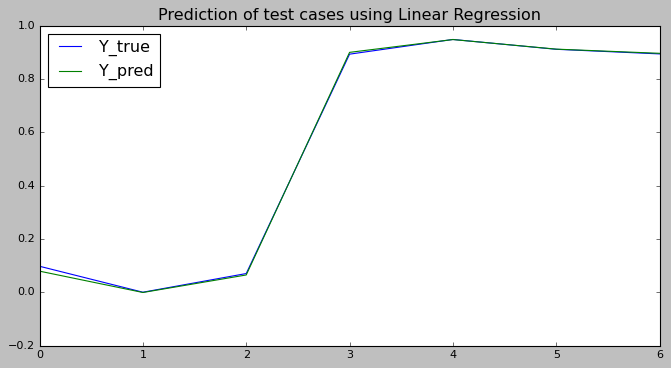

In [756]:
results.plot(title = 'Prediction of test cases using Linear Regression', figsize = (10,5), fontsize = 10)

In [0]:
Y_pred_all = regr.predict(merged_df_scaled[['positive tweets', 'negative tweets',
       'neutral tweets']])


In [0]:
list_of_lists = list(Y_pred_all)
Y_pred_all = [val for sublist in list_of_lists for val in sublist]

In [0]:
results_all = pd.DataFrame({'Y_true':list(merged_df_scaled['Total']), 
              'Y_pred_all': Y_pred_all})
results_all.index = merged_df_scaled.index

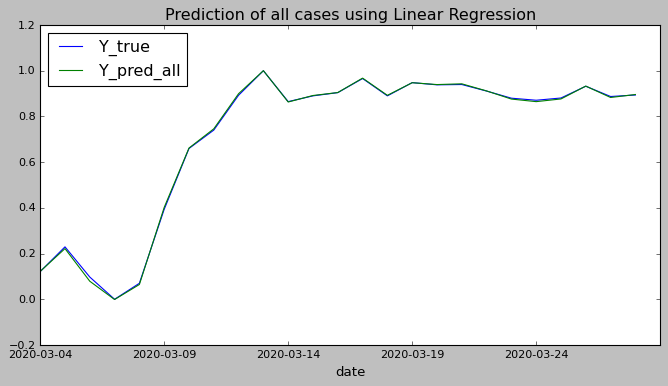

In [761]:

results_all.plot(title = 'Prediction of all cases using Linear Regression', figsize = (10,5), fontsize = 10)

In [762]:
results_all

,Y_true,Y_pred_all
date,,
2020-03-04,0.121182,0.121970
2020-03-05,0.229407,0.221770
2020-03-06,0.097334,0.078972
2020-03-07,0.000000,-0.000997
2020-03-08,0.070067,0.064704
2020-03-09,0.393556,0.401773
2020-03-10,0.659705,0.661671
2020-03-11,0.740254,0.745783
2020-03-12,0.892729,0.899484
